# Cross Entropy Loss

Following tutorial [here](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning).

Notes:

> cross-entropy (CE) is primarily a loss function for classification, measuring the difference between predicted probabilities and true class labels, while Mean Squared Error (MSE) is standard for regression (predicting continuous values). However, CE can be adapted for regression if target distributions are assumed (like Gaussian), effectively becoming MSE, but its core strength lies in classification problems with categorical or probabilistic outputs

In [ ]:
# ==============================================================================
# Environment Setup - Run this cell first!
# ==============================================================================
# This cell handles both local and Google Colab environments.
# Copy this cell to the start of every notebook.

import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    import subprocess

    REPO_URL = "https://github.com/trvslhlt/ift_6135_representation_learning.git"
    REPO_PATH = Path("/content/ift_6135_representation_learning")

    if REPO_PATH.exists():
        print("Updating repository...")
        subprocess.run(["git", "-C", str(REPO_PATH), "pull"], check=True)
    else:
        print("Cloning repository...")
        subprocess.run(["git", "clone", REPO_URL, str(REPO_PATH)], check=True)

    print("Installing dependencies...")
    %pip install -q -e {REPO_PATH}

    sys.path.insert(0, str(REPO_PATH / "src"))
    %cd {REPO_PATH}
else:
    # Local: find repo root and add src to path
    REPO_PATH = Path.cwd()
    while not (REPO_PATH / "pyproject.toml").exists() and REPO_PATH != REPO_PATH.parent:
        REPO_PATH = REPO_PATH.parent
    sys.path.insert(0, str(REPO_PATH / "src"))

print(f"\nEnvironment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Repository: {REPO_PATH}")


Environment: Local
Repository: /Users/travisholt/github/trvslhlt/ift_6135_representation_learning


In [37]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [38]:
# create training data
X, y = make_classification(
    n_samples=10000,
    n_informative=10,
    random_state=2022
)

# split into train and test
X_new, X_test = X[:9000, :], X[9000:, ]
y_new, y_test = y[:9000], y[9000:]

X_train, X_val, y_train, y_val = train_test_split(
    X_new, y_new,
    test_size=0.3
)
print(f"Train data: {X_train.shape}\n\
Train labels: {y_train.shape}\n\
Test data: {X_test.shape}\n\
Test labels: {y_test.shape}")

"""
Train data: (6300, 20)
Train labels: (6300,)
Test data: (1000, 20)
Test labels: (1000,)
"""

Train data: (6300, 20)
Train labels: (6300,)
Test data: (1000, 20)
Test labels: (1000,)


'\nTrain data: (6300, 20)\nTrain labels: (6300,)\nTest data: (1000, 20)\nTest labels: (1000,)\n'

In [39]:
# convert numpy arrays to tensors 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

# build the model
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
    )

print(model)

"""
Sequential(
  (0): Linear(in_features=20, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)
"""

Sequential(
  (0): Linear(in_features=20, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)


'\nSequential(\n  (0): Linear(in_features=20, out_features=10, bias=True)\n  (1): ReLU()\n  (2): Linear(in_features=10, out_features=10, bias=True)\n  (3): ReLU()\n  (4): Linear(in_features=10, out_features=1, bias=True)\n  (5): Sigmoid()\n)\n'

In [40]:
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
num_epochs = 5
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        v_loss = loss_fn(val_outputs, y_val_tensor)
        val_loss.append(v_loss.item())
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: train_loss={loss.item():.4f}, val_loss={v_loss.item():.4f}')


Epoch 5: train_loss=0.6970, val_loss=0.6964


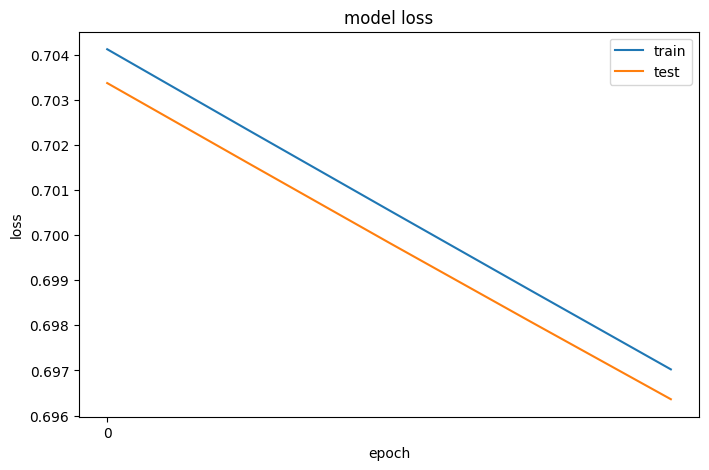

In [42]:
# plotting the loss of the models
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,num_epochs, step=10))
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [43]:
'''
Tensorflow batches during each epoch by default. Pytorch requires manual batching.
This is an implementation of batching in Pytorch. We now see similar loss reduction over epochs as tensorflow.
'''

from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 20
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / len(trainloader))
    
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            epoch_val_loss += loss_fn(outputs, labels).item()
    val_loss.append(epoch_val_loss / len(valloader))

print(f'Final: train_loss={train_loss[-1]:.4f}, val_loss={val_loss[-1]:.4f}')


Final: train_loss=0.1149, val_loss=0.1173


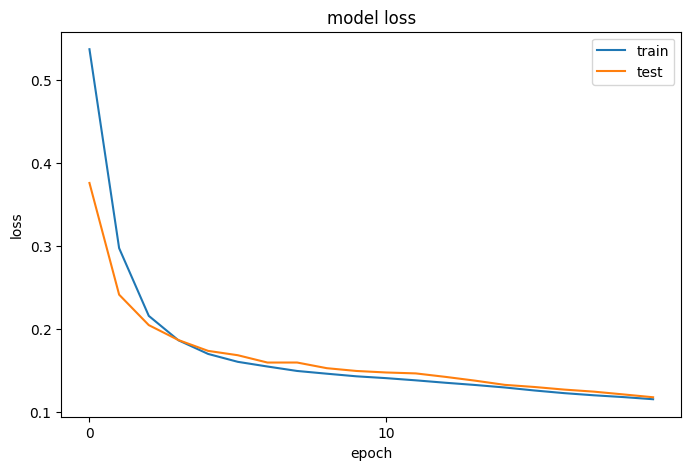

In [44]:
# plotting the loss of the models
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,num_epochs, step=10))
plt.legend(['train', 'test'], loc='upper right')
plt.show()